In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

2024-04-26 14:50:08.518266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 14:50:08.518364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 14:50:08.690888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_path= '../input/thermography-images-of-diabetic-foot/ThermoDataBase/train'
test_path='../input/thermography-images-of-diabetic-foot/ThermoDataBase/val'

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1444 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class SE_Inception_resnet_v2_Layer(Layer):
    def __init__(self, input_shape=(224, 224, 3), classes=1000):
        super(SE_Inception_resnet_v2_Layer, self).__init__()
        self.se_inception_resnet_v2_model = self.build_model(input_shape, classes)

    def build_model(self, input_shape, classes):
        input_tensor = Input(shape=input_shape)

        # Define SE-Inception-ResNet-v2 model
        # Implement SE-Inception-ResNet-v2 architecture here

        output_tensor = input_tensor  # Placeholder for the output tensor
        model = Model(inputs=input_tensor, outputs=output_tensor)
        return model

    def call(self, inputs):
        return self.se_inception_resnet_v2_model(inputs)

# Create SE-Inception-ResNet-v2 layer
se_inception_resnet_v2_layer = SE_Inception_resnet_v2_Layer()

# Add additional layers
inputs = Input(shape=(224, 224, 3))
x = se_inception_resnet_v2_layer(inputs)
x = GaussianNoise(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = GaussianNoise(0.25)(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine SE-Inception-ResNet-v2 layer and additional layers
model = Model(inputs=inputs, outputs=predictions)

# Freeze layers in the base model
se_inception_resnet_v2_layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se__inception_resnet_v2__layer… │ (None, 224, 224, 3)    │             0 │
│ (SE_Inception_resnet_v2_Layer)  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 3)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 256)            │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adamw',
              metrics=['accuracy','AUC','Precision','Recall'])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - AUC: 0.6596 - Precision: 0.7175 - Recall: 0.5938 - accuracy: 0.6414 - loss: 0.6854
Epoch 1: val_accuracy improved from -inf to 0.81754, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 304ms/step - AUC: 0.6606 - Precision: 0.7169 - Recall: 0.5945 - accuracy: 0.6420 - loss: 0.6853 - val_AUC: 0.8966 - val_Precision: 0.9070 - val_Recall: 0.7738 - val_accuracy: 0.8175 - val_loss: 0.4411
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - AUC: 0.7551 - Precision: 0.6724 - Recall: 0.6725 - accuracy: 0.7197 - loss: 0.5858
Epoch 2: val_accuracy did not improve from 0.81754
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - AUC: 0.7557 - Precision: 0.6739 - Recall: 0.6724 - accuracy: 0.7199 - loss: 0.5852 - val_AUC: 0.8408 - val_Precision: 0.7962 - val_Recall: 0.8214 - val_accuracy: 0.7678 - val_loss: 0.4681
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - AUC: 0.7490 - Precision: 0.7632 - Recall: 0.6237 - accuracy: 0.7027 - loss: 0.6459
Ep

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 8: val_accuracy did not improve from 0.81991
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - AUC: 0.7489 - Precision: 0.7249 - Recall: 0.6070 - accuracy: 0.6692 - loss: 0.6361 - val_AUC: 0.8935 - val_Precision: 0.9029 - val_Recall: 0.7381 - val_accuracy: 0.7962 - val_loss: 0.4247
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.8450 - Precision: 0.8922 - Recall: 0.6755 - accuracy: 0.7796 - loss: 0.4885
Epoch 9: val_accuracy did not improve from 0.81991
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - AUC: 0.8438 - Precision: 0.8893 - Recall: 0.6748 - accuracy: 0.7782 - loss: 0.4899 - val_AUC: 0.8859 - val_Precision: 0.9029 - val_Recall: 0.7381 - val_accuracy: 0.7962 - val_loss: 0.4162
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - AUC: 0.7172 - Precision: 0.7413 - Recall: 0.6548 - accuracy: 0.6853 - loss: 0.6076
Epoch 10: val_accuracy did not improve from 0.81991
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - AUC: 0.7187 - Precision: 0.7424 - Recall: 0.6546 - accuracy: 0.68

In [32]:
model.evaluate(validation_generator)

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - AUC: 0.8913 - Precision: 0.9157 - Recall: 0.7269 - accuracy: 0.7959 - loss: 0.4314


[0.4348747730255127,
 0.7914692163467407,
 0.8884570598602295,
 0.9019607901573181,
 0.7301587462425232]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
[[0.94590116]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


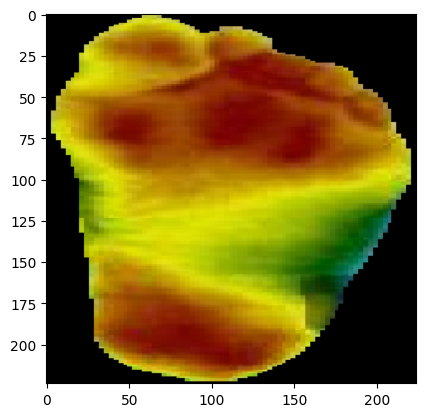

In [33]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('../input/thermography-images-of-diabetic-foot/ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))